<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:

import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

scaler = MinMaxScaler()

stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Preprocessing_Data/Preprocessing_Neumeric_Data/neumeric_preprocess_kospi.csv')
stock_data

,Date,Kospi_open,Kospi_high,Kospi_low,Kospi_close,Kospi_vol,dji_open,dji_high,dji_low,dji_close,...,gold_close,gold_vol,oil_open,oil_high,oil_low,oil_close,oil_vol,ko_interest,ko_consumer,ko_real_estate
0,20200102,0.396918,0.381014,0.394615,2175.17,0.063453,0.543149,0.546881,0.565298,0.564424,...,0.310484,0.034935,0.357855,0.353594,0.370475,0.360653,0.000267,0.25,0.055603,1.000000
1,20200103,0.392204,0.381603,0.391140,2176.46,0.106757,0.538309,0.538105,0.558382,0.551577,...,0.315092,0.141863,0.377182,0.371250,0.390883,0.378227,0.000003,0.25,0.055603,1.000000
2,20200106,0.371664,0.359951,0.382821,2155.07,0.094452,0.533345,0.537640,0.553946,0.555339,...,0.304724,0.150331,0.381234,0.375312,0.388716,0.376081,0.000202,0.25,0.055603,1.000000
3,20200107,0.378015,0.369510,0.390537,2175.54,0.086702,0.543161,0.536378,0.561906,0.548765,...,0.309332,0.114978,0.374377,0.368437,0.388057,0.375428,0.000010,0.25,0.055603,1.000000
4,20200108,0.372374,0.358784,0.376232,2151.31,0.196021,0.538468,0.546510,0.559584,0.557629,...,0.271889,0.155070,0.347880,0.346594,0.361370,0.353686,0.000540,0.25,0.055603,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,20230623,0.614191,0.602480,0.608100,2570.10,0.073512,0.836843,0.825199,0.837724,0.831268,...,0.193548,0.241288,0.651496,0.646250,0.667169,0.651944,0.000000,1.00,0.999145,0.288566
829,20230626,0.597594,0.593865,0.604846,2582.20,0.058550,0.830916,0.824292,0.835760,0.830570,...,0.199885,0.179740,0.651496,0.646250,0.667169,0.651944,0.000000,1.00,0.999145,0.288566
830,20230627,0.604350,0.592026,0.608343,2581.39,0.076327,0.831382,0.833050,0.842278,0.842215,...,0.205069,0.162962,0.651496,0.646250,0.667169,0.651944,0.000000,1.00,0.999145,0.288566
831,20230628,0.609538,0.596761,0.603461,2564.19,0.060132,0.839427,0.829018,0.843664,0.838146,...,0.201613,0.180904,0.651496,0.646250,0.667169,0.651944,0.000000,1.00,0.999145,0.288566


In [3]:
def preprocess_numeric_data(df):

    # 데이터들 소수점 3자리까지 조절
    df = df.round(3)

    # 종가들을 제외하고 스케일링을 진행하기위해서 우선 칼럼들의 이름을 뽑아내기
    df_names = df.columns.tolist()

    # 종가 열(Kospi_close, Kosdaq_close)을 데이터프레임에서 제외
    col_to_drop = [col for col in df.columns if 'Kospi_close' in col or 'Kosdaq_close' in col]
    df_col = df.columns.tolist()
    # 날짜 열(Date)을 데이터프레임에서 제외
    df_col.remove('Date')
    x_col = [item for item in df_col if item not in col_to_drop]

    # MinMax Scaling 적용
    columns_to_scale = x_col  # 스케일링을 적용할 열 목록
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df

In [4]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
# stock_data = preprocess_numeric_data(stock_data)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

In [5]:
name = [stock_data.columns]

close = ['Kospi_open', 'Kospi_high', 'Kospi_low', 'Kospi_vol', 'dji_open',
       'dji_high', 'dji_low', 'dji_vol', 'us500_open',
       'us500_high', 'us500_low', 'us500_vol', 'ex_AM_open',
       'ex_AM_high', 'ex_AM_low', 'ex_JP_open', 'ex_JP_high',
       'ex_JP_low', 'ko_interest', 'ko_consumer',
       'ko_real_estate']

close_only = ['Kospi_open', 'Kospi_high', 'Kospi_low', 'Kospi_vol', 'dji_open',
       'dji_high', 'dji_low','dji_vol', 'us500_open',
       'us500_high', 'us500_low', 'us500_vol', 'ex_AM_open',
       'ex_AM_high', 'ex_AM_low', 'ex_JP_open', 'ex_JP_high',
       'ex_JP_low']

stock_data_close = stock_data.drop(close, axis=1)
stock_data_close_only = stock_data.drop(close_only, axis=1)

In [6]:
stock_data_close_only.tail(5)

,dji_close,us500_close,ex_AM_close,ex_JP_close,gold_open,gold_high,gold_low,gold_close,gold_vol,oil_open,oil_high,oil_low,oil_close,oil_vol,ko_interest,ko_consumer,ko_real_estate
828,0.831268,0.825827,0.595454,0.024771,0.183435,0.140754,0.211894,0.193548,0.241288,0.651496,0.64625,0.667169,0.651944,0.0,1.0,0.999145,0.288566
829,0.830570,0.818195,0.621711,0.037729,0.180656,0.151355,0.211894,0.199885,0.179740,0.651496,0.64625,0.667169,0.651944,0.0,1.0,0.999145,0.288566
830,0.842215,0.837595,0.607805,0.027820,0.187326,0.144876,0.207852,0.205069,0.162962,0.651496,0.64625,0.667169,0.651944,0.0,1.0,0.999145,0.288566
831,0.838146,0.836989,0.590985,0.000000,0.181212,0.139576,0.216513,0.201613,0.180904,0.651496,0.64625,0.667169,0.651944,0.0,1.0,0.999145,0.288566
832,0.852962,0.844649,0.625430,0.020960,0.176209,0.142521,0.208430,0.203341,0.157558,0.651496,0.64625,0.667169,0.651944,0.0,1.0,0.999145,0.288566


In [7]:
# 데이터 분할
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t, test_data_t = stock_data[:train_size], stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t, train_data, look_back)
testX, testY = create_dataset(test_data_t,test_data, look_back)
print(trainX.shape)
print(trainY.shape)

(656, 10, 35)
(656, 1)


In [8]:
earlystopping = EarlyStopping(monitor='val_loss', patience=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 1024)          3259392   
                                                                 
 dropout (Dropout)           (None, 10, 1024)          0         
                                                                 
 gru_1 (GRU)                 (None, 10, 512)           2362368   
                                                                 
 dropout_1 (Dropout)         (None, 10, 512)           0         
                                                                 
 gru_2 (GRU)                 (None, 10, 256)           591360    
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 10, 128)           1

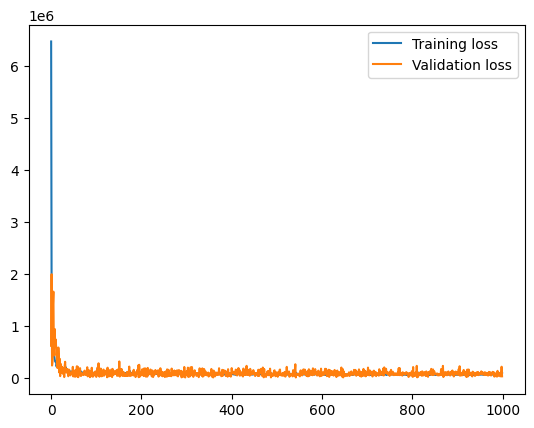

5/5 [==============================] - 1s 132ms/step


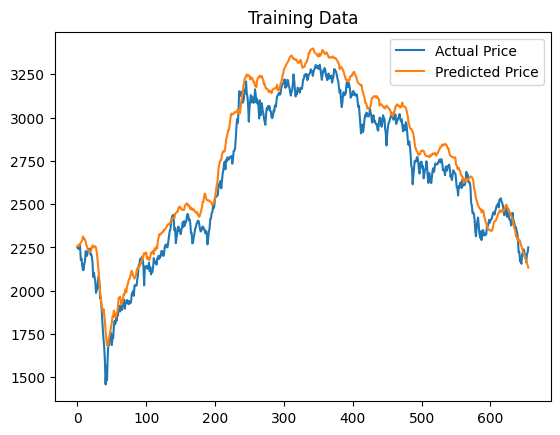

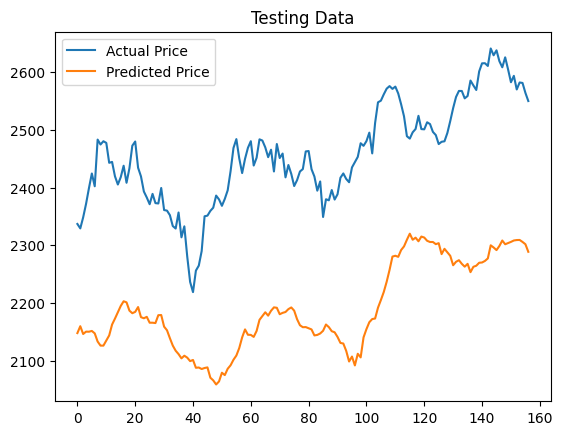

In [9]:
# 모델 생성
model = Sequential()
# model.add(Bidirectional(LSTM(units=1024, activation='relu', return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.1))
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.1))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.1))
# model.add(GRU(units=16, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [10]:
# # 데이터 분할
# train_size = int(len(data) * 0.8)
# train_data, test_data = data[:train_size], data[train_size:]
# train_data_t, test_data_t = stock_data_close[:train_size], stock_data_close[train_size:]

# def create_dataset(dataset, data, look_back=10):
#     X, y = [], []
#     for i in range(len(data) - look_back):
#         X.append(dataset[i:(i + look_back)])
#         y.append(data[i + look_back])
#     return np.array(X), np.array(y)

# look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

# trainX, trainY = create_dataset(train_data_t, train_data, look_back)
# testX, testY = create_dataset(test_data_t,test_data, look_back)
# print(trainX.shape)
# print(trainY.shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             6784      
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 gru_6 (GRU)                 (None, 4, 512)            887808    
                                                                 
 dropout_6 (Dropout)         (None, 4, 512)            0         
                                                                 
 gru_7 (GRU)                 (None, 4, 256)            591360    
                                                                 
 dropout_7 (Dropout)         (None, 4, 256)            0         
                                                      

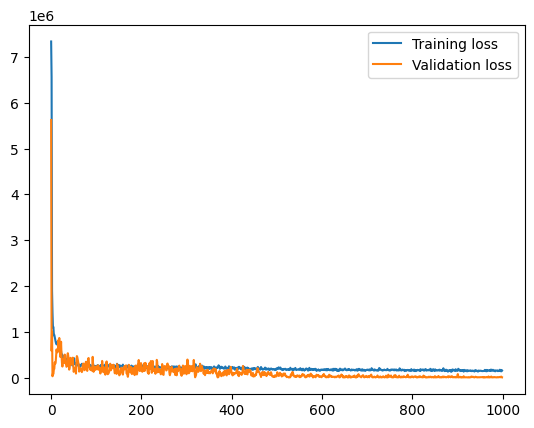

5/5 [==============================] - 0s 22ms/step


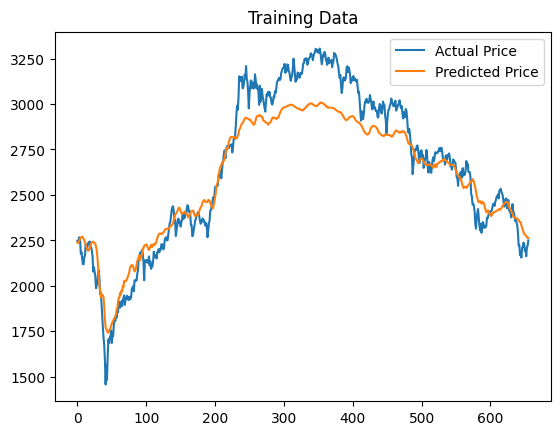

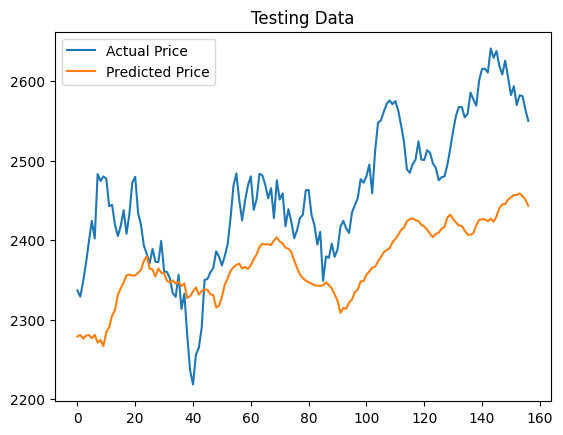

In [11]:
# 모델 생성
model = Sequential()
# model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()


loss = Huber()
optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [12]:
# # 데이터 분할
# train_size = int(len(data) * 0.8)
# train_data, test_data = data[:train_size], data[train_size:]
# train_data_t, test_data_t = stock_data_close_only[:train_size], stock_data_close_only[train_size:]

# def create_dataset(dataset, data, look_back=10):
#     X, y = [], []
#     for i in range(len(data) - look_back):
#         X.append(dataset[i:(i + look_back)])
#         y.append(data[i + look_back])
#     return np.array(X), np.array(y)

# look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

# trainX, trainY = create_dataset(train_data_t, train_data, look_back)
# testX, testY = create_dataset(test_data_t,test_data, look_back)
# print(trainX.shape)
# print(trainY.shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 64)             6784      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 4, 1024)           4460544   
                                                                 
 dropout_12 (Dropout)        (None, 4, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 512)            3147776   
                                                                 
 dropout_13 (Dropout)        (None, 4, 512)            0         
                                                      

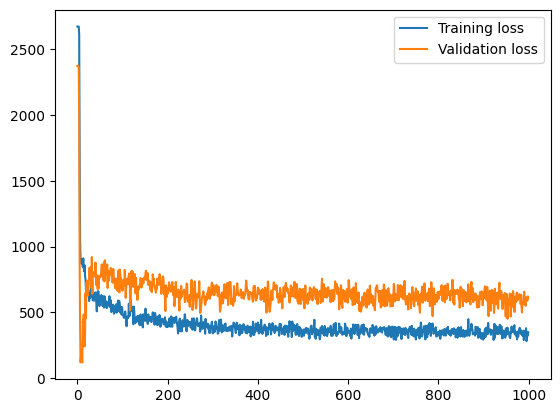

5/5 [==============================] - 0s 78ms/step


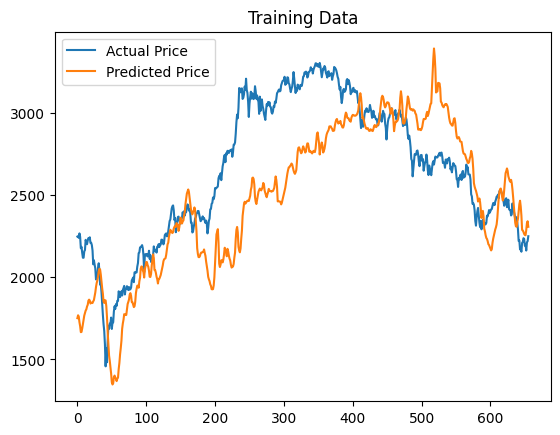

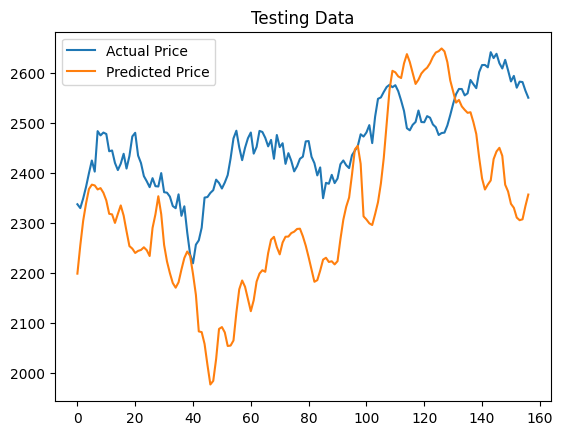

In [13]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [14]:
#양방향 lstm + 코드의 깊이 증가 및 유닛의 수 증가로 바꿔주는 코드


# model = Sequential()
# model.add(Bidirectional(LSTM(units=1024, activation='relu', return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2]))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=512, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=256, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=128, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=64, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=32, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=16, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(units=1))
# model.summary()

In [15]:
# model = Sequential()

# Add a Convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))
# model.add(MaxPooling1D(pool_size=2)

# # Add LSTM layers
# model.add(LSTM(units=1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=512, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=256, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=128, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=64, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=16, activation='relu'))
# model.add(Dropout(0.1))

# # Add the output Dense layer
# model.add(Dense(units=1))

# model.summary()

In [16]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename,
#                              save_weights_only=True,
#                              save_best_only=True,
#                              monitor='val_loss',
#                              verbose=1)

# history = model.fit(train_data,
#                     validation_data=(test_data),
#                     epochs=50,
#                     callbacks=[checkpoint, earlystopping])

# model.load_weights(filename)